In [1]:
import pandas as pd
pd.set_option("display.width", 380)
pd.set_option('max_colwidth', 200)
import numpy as np

from langdetect import detect

from IPython.display import display

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import pickle

#To handle warning
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
df = pd.read_csv("./dataLemmatized.csv", sep=',')

## Distribution of articles over the years
With an average of 73 articles per year for a standard deviation of 18, there is a difference between years, but it is reasonable.

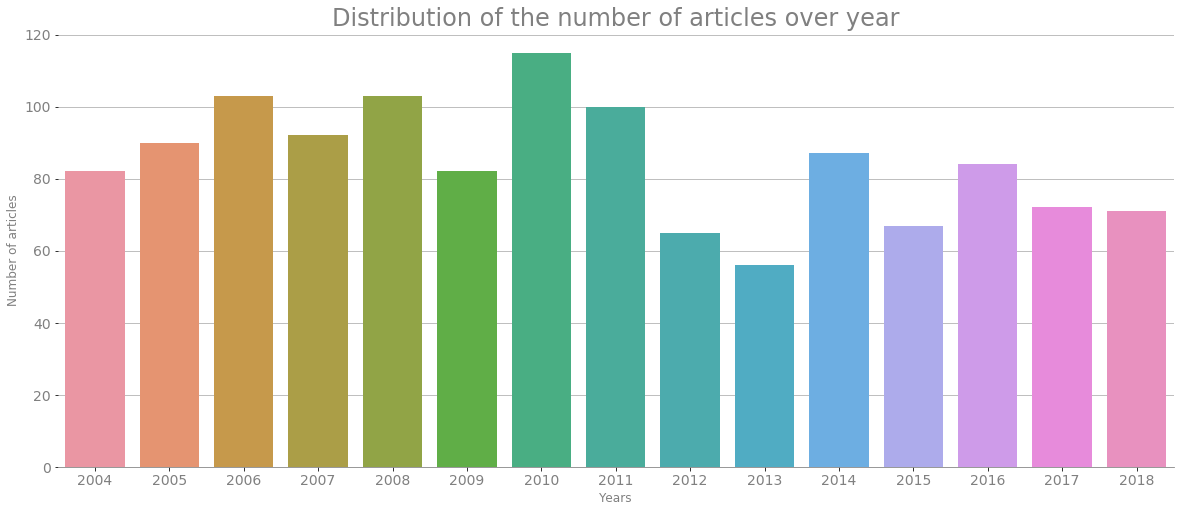

Grand total of 1269 articles


In [3]:
invYr = df.groupby(['year']).count()
sns.barplot(x=invYr.index, y=invYr.series)
plt.title("Distribution of the number of articles over year", fontsize= 24, color='gray')
plt.ylabel("Number of articles", fontsize=12, color='gray')
plt.xlabel("Years", fontsize=12, color='gray')
fig=plt.gcf()
fig.set_size_inches(20,8)

## PlotSwagg ##
plt.yticks(fontsize=14, rotation=0, color='gray')
plt.xticks(fontsize=14, rotation=0, color='gray')

# Less border
plt.gca().yaxis.grid(True)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_edgecolor('gray')

# line under the bar
plt.gca().set_axisbelow(True)

plt.show()
print("Grand total of %d articles" % len(df))

## Lemmatization and tokenization was performed beforehand

In [4]:
# Do the French Lem and Prepros
df['lem_prepro_title'] = df['titleLemma']
df['lem_prepro_abstract'] =  df['abstractLemma']

# Display the result
display(df[['lem_prepro_title' ,'lem_prepro_abstract']].head())

,lem_prepro_title,lem_prepro_abstract
0,plateforme citoyen dédié analyser tweets événement politique,plateforme objectif permettre citoyen analyserpar même tweets politique événement spécifique france élection présidentiel analyser quasitemps message candidat fournir principal caractéristique usa...
1,algorithme clustering niveau grand ensemble donnée,classification croisé clustering technique permettre extraire structuresous jacent existant entre ligne colonne tabler donnée forme bloc plusieurs application utiliser technique cependant nombreux...
2,algeospf modèle factorisation clustering géographique recommandation,recommandation point intérêt devenir caractéristiqueessentielle réseau social localiser accompagnél émergence échange massif donnée digital cependantles faible densités point intérêt visiter utili...
3,analyser sentiment partir commentaire facebook publier arabe standard dialectal marocain approche apprentissage automatique,analyser sentiment processus pendant lequel polarité positif négatif neutre texte donner déterminé intéressonsdans travail analyser sentiment partir commentairesfacebook réel partager arabe standa...
4,analyser rôle sémantique résumer automatique,article présent approcher viser extraire information expriméesdans corpus texte produire résumer plusieurs variante deméthodes extractif résumer texte implémenter évaluer leurprincipale originalit...


## Remove Stopwords

In [5]:
# Custom Stop words
custom_stop_words = ['algorithme', 'étude', 'méthode', 'approche', 'nouvelle', 'algorithme', 'automatique', 'système'
                    'source', 'exemple', 'concevoir', 'ensuite', 'définir', 'effectuer', 'permettre', "ainsi", "entre", 'point', 'base'
                    'souvent', 'utiliser', 'variable', 'donner', 'technique', 'masse']

stopList = custom_stop_words + open('stoplist.txt','r',encoding='utf-8').read().split('\n')

language = open('langues.txt','r',encoding='utf-8').read().lower().split('\n')

def retraitement(txt):
    tmp = []
    if(type(txt) == str):
        for w in txt.split(' '):
            #regroupement langues
            if w in language:
                tmp.append('[langue]')
            elif w not in stopList:
                tmp.append(w)
    return " ".join(tmp)

#les changements se font bien mais pas possible de les stocker dans la colonne correspondante
df['lem_prepro_abstract'] = df.abstractLemma.apply(lambda x: retraitement(x))
df['lem_prepro_title'] = df.titleLemma.apply(lambda x: retraitement(x))

## Selection of the feature on which the analysis will be performed

In [6]:
# with ou without the abstract
WITH_ABST = True

def join_with_nan(subset_df):
    res = []
    if subset_df['lem_prepro_title'] is not pd.np.nan:
        res += subset_df['lem_prepro_title'].split()
    if WITH_ABST and subset_df['lem_prepro_abstract'] is not pd.np.nan:
        res += subset_df['lem_prepro_abstract'].split()
    return res

# Join the lematized title and abstract
df_all_lem = df.apply(join_with_nan, axis=1)
display(df_all_lem.head())


0    [plateforme, citoyen, dédié, analyser, tweets, événement, politique, plateforme, objectif, citoyen, analyserpar, même, tweets, politique, événement, spécifique, france, élection, présidentiel, ana...
1    [clustering, donnée, classification, croisé, clustering, extraire, structuresous, jacent, ligne, colonne, tabler, donnée, forme, bloc, clustering, actuel, passer, échelle, succès, optimiser, critè...
2    [algeospf, modèle, factorisation, clustering, géographique, recommandation, recommandation, intérêt, devenir, caractéristiqueessentielle, réseau, social, localiser, accompagnél, émergence, échange...
3    [analyser, sentiment, commentaire, facebook, publier, [langue], standard, dialectal, [langue], apprentissage, analyser, sentiment, processus, pendant, lequel, polarité, positif, négatif, neutre, t...
4    [analyser, rôle, sémantique, résumer, article, présent, approcher, viser, extraire, information, expriméesdans, corpus, texte, produire, résumer, variante, deméthodes, extract

## Create the Dictionary and Corpus needed for Topic Modeling
[source](https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24)

In [7]:
import gensim

# Create Dictionary
id2word = gensim.corpora.Dictionary(df_all_lem)

count = 0
for k, v in id2word.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 analyser
1 analyserpar
2 candidat
3 caractéristique
4 citoyen
5 comparaison
6 dédié
7 fournir
8 france
9 lexique
10 message


## Remove tokens from the dictionary before Topic Modeling

In [8]:
# Filter out tokens that appear in 
id2word.filter_extremes(no_below=1,   # - less than X documents (absolute number)
                        no_above=0.92, # - more than X documents (fraction of total corpus size, not absolute number)
                        keep_n=1000)  # - after the above two steps, keep only the first X most frequent tokens.

bow_corpus = [id2word.doc2bow(doc) for doc in df_all_lem]

In [9]:
first_bow_doc = bow_corpus[0]

# Pandas df
display(", ".join(df_all_lem[0]))

# bow representation
for i in range(len(first_bow_doc)):
    print("Word {} (\"{}\") appears {} time.".format(first_bow_doc[i][0],
                                               id2word[first_bow_doc[i][0]],
                                               first_bow_doc[i][1]))

'plateforme, citoyen, dédié, analyser, tweets, événement, politique, plateforme, objectif, citoyen, analyserpar, même, tweets, politique, événement, spécifique, france, élection, présidentiel, analyser, quasitemps, message, candidat, fournir, principal, caractéristique, usage, lexique, politique, comparaison, candidat'

Word 0 ("analyser") appears 2 time.
Word 1 ("candidat") appears 2 time.
Word 2 ("caractéristique") appears 1 time.
Word 3 ("comparaison") appears 1 time.
Word 4 ("dédié") appears 1 time.
Word 5 ("fournir") appears 1 time.
Word 6 ("france") appears 1 time.
Word 7 ("message") appears 1 time.
Word 8 ("même") appears 1 time.
Word 9 ("objectif") appears 1 time.
Word 10 ("plateforme") appears 2 time.
Word 11 ("politique") appears 3 time.
Word 12 ("principal") appears 1 time.
Word 13 ("spécifique") appears 1 time.
Word 14 ("tweets") appears 2 time.
Word 15 ("usage") appears 1 time.
Word 16 ("événement") appears 2 time.


## tf-idf

In [10]:
tfidf = gensim.models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
for doc in corpus_tfidf:
    display(doc)
    break

[(0, 0.11743871273103482),
 (1, 0.344473385045115),
 (2, 0.12064790358704418),
 (3, 0.12064790358704418),
 (4, 0.18912176955372884),
 (5, 0.1056273910910164),
 (6, 0.1722366925225575),
 (7, 0.16713365785861597),
 (8, 0.16960006148140025),
 (9, 0.08857208664147208),
 (10, 0.3099272650846593),
 (11, 0.5673653086611865),
 (12, 0.10965384773948775),
 (13, 0.13117304567136392),
 (14, 0.37824353910745767),
 (15, 0.14857949493967418),
 (16, 0.29149477050228767)]

## Building the Topic Model

In [11]:
USE_TF_IDF = True

corpus_for_lda = bow_corpus
if USE_TF_IDF:
    corpus_for_lda = corpus_tfidf

lda_model = gensim.models.LdaMulticore(corpus_tfidf, num_topics=50, id2word=id2word, passes=10, iterations=100,  workers=4, eval_every=None)

In [12]:
for idx, topic in lda_model.print_topics(-1)[:5]:
    print('\nTopic: {} \nWords: {}'.format(idx, topic))


Topic: 0 
Words: 0.064*"thématique" + 0.029*"industrie" + 0.028*"[langue]" + 0.027*"conférence" + 0.026*"action" + 0.023*"collaboratif" + 0.019*"collection" + 0.019*"auteur" + 0.018*"publication" + 0.017*"industriel"

Topic: 1 
Words: 0.028*"service" + 0.025*"relatif" + 0.022*"quantitatif" + 0.020*"validation" + 0.018*"médical" + 0.018*"protocole" + 0.016*"impact" + 0.016*"ontologie" + 0.015*"conceptuel" + 0.014*"recommandation"

Topic: 2 
Words: 0.041*"agent" + 0.027*"simulation" + 0.026*"mining" + 0.024*"humain" + 0.018*"stratégie" + 0.018*"rappel" + 0.013*"définition" + 0.012*"outil" + 0.011*"charge" + 0.011*"distinct"

Topic: 3 
Words: 0.021*"assister" + 0.020*"lequel" + 0.019*"durant" + 0.019*"affiner" + 0.012*"croissance" + 0.012*"social" + 0.012*"diagnostic" + 0.011*"conjointement" + 0.011*"sommet" + 0.010*"média"

Topic: 4 
Words: 0.062*"recommandation" + 0.026*"contingence" + 0.024*"client" + 0.021*"tableau" + 0.017*"voisinage" + 0.016*"populaire" + 0.016*"variante" + 0.015*"

## Visualize the topics-keywords

In [13]:
import pyLDAvis.gensim
from metakernel.display import display

try:
    lda_display = pyLDAvis.gensim.prepare(lda_model, bow_corpus, id2word, sort_topics=False)
    pyLDAvis.display(lda_display)
except:
    print("Couldn't plot the LDA viewer")

## Evaluate LDA
The Coherence score is used for evaluation of topic models.  
[paper](http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf)

In [14]:
from gensim.models.coherencemodel import CoherenceModel

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=df_all_lem, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.3599440985265805


## Find the optimal number of topics for LDA
Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics.

If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.  
[source](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/)

In [15]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    import warnings
    warnings.filterwarnings('ignore')
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

if False:
    
    for keep_first_most_frz in np.logspace(1, 4, 4):
        keep_first_most_frz = int(keep_first_most_frz)
        display(keep_first_most_frz)
        
        id2word = gensim.corpora.Dictionary(df_all_lem)
        
        # Filter out tokens that appear in 
        id2word.filter_extremes(no_below=10,   # - less than X documents (absolute number)
                                no_above=0.90, # - more than X documents (fraction of total corpus size, not absolute number)
                                keep_n=keep_first_most_frz)  # - after the above two steps, keep only the first X most frequent tokens.

        bow_corpus = [id2word.doc2bow(doc) for doc in df_all_lem]

        tfidf = gensim.models.TfidfModel(bow_corpus)
        corpus_tfidf = tfidf[bow_corpus]
        

        keep_first_most_frz = str(keep_first_most_frz)
        for corpus_type, file in [(corpus_tfidf, "coherence_values_per_topics_tfidf_"+keep_first_most_frz+".pickle"),
                                  (bow_corpus,"coherence_values_per_topics_bow"+keep_first_most_frz+".pickle")]:
            # Can take a long time to run.
            limit=900; start=10; step=35;
            model_list, coherence_values = compute_coherence_values(
                dictionary=id2word,
                corpus=corpus_type,
                texts=df_all_lem,
                start=start,
                limit=limit,
                step=step)

            x = range(start, limit, step)
            pickle.dump((x, coherence_values), open("./pickle/" + file, 'wb'))

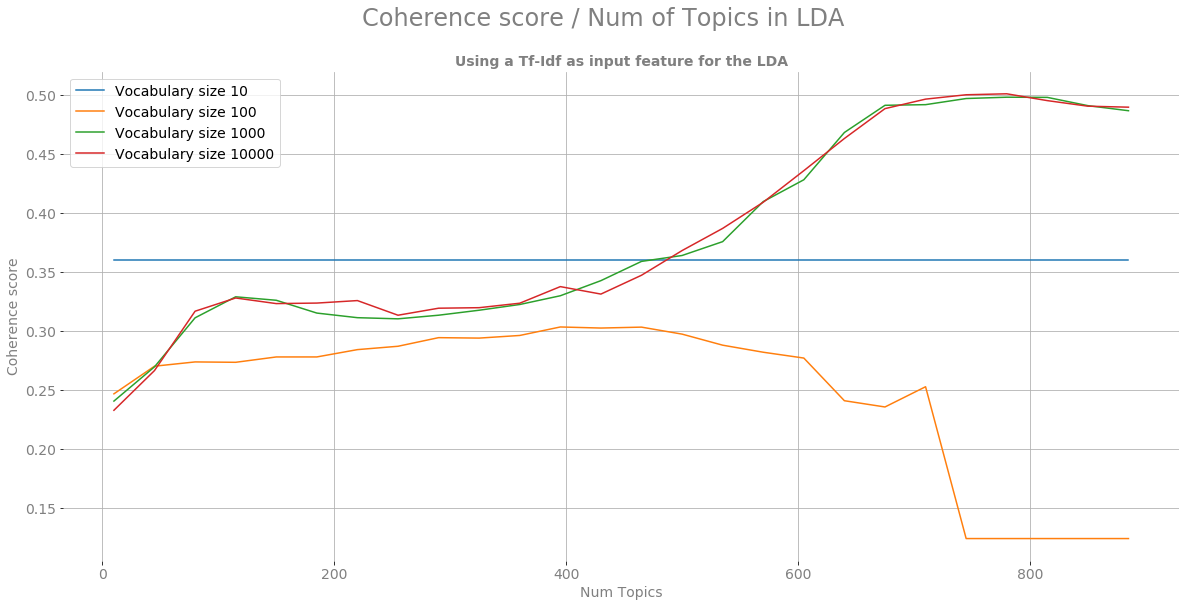

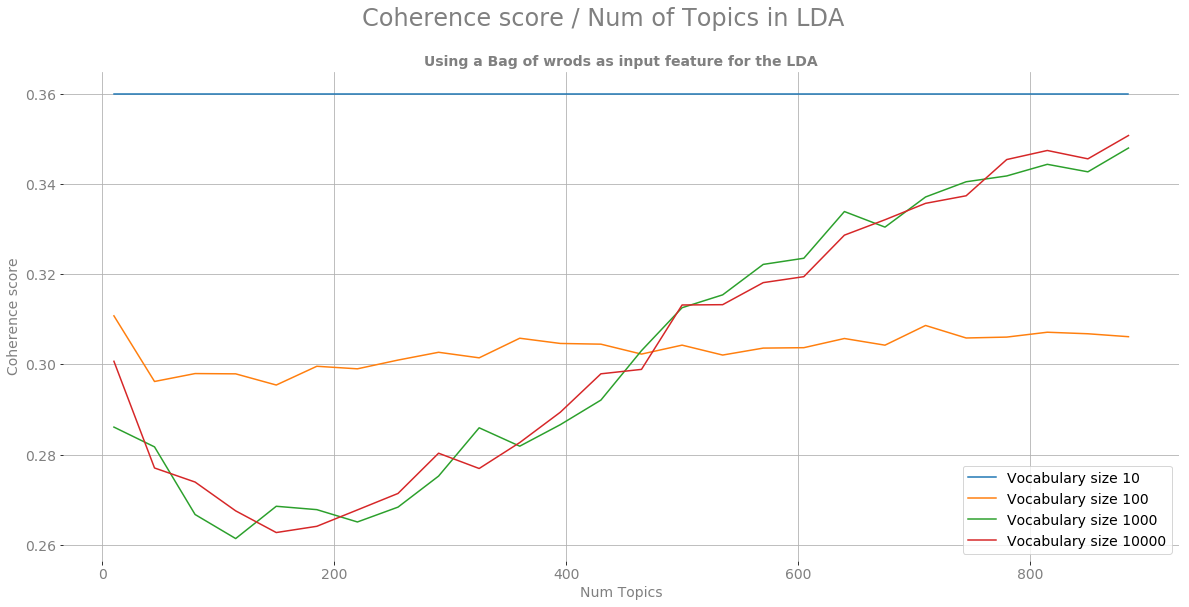

In [16]:
for corpus_type, _file in [("Tf-Idf", "coherence_values_per_topics_tfidf_"),
                          ("Bag of wrods","coherence_values_per_topics_bow")]:
        
    legend = []
    for keep_first_most_frz in np.logspace(1, 4, 4):
        keep_first_most_frz = int(keep_first_most_frz)
        keep_first_most_frz = str(keep_first_most_frz)
        
        # From pickle
        file = open("./pickle/" + _file + keep_first_most_frz+".pickle",'rb')
        (x, coherence_values) = pickle.load(file)

        # Show graph
        fig_size = plt.rcParams["figure.figsize"]
        fig_size[0] = 20
        fig_size[1] = 9
        plt.rcParams["figure.figsize"] = fig_size

        _leg, = plt.plot(x, coherence_values, label='Vocabulary size ' + keep_first_most_frz)
        legend.append(_leg)
        plt.suptitle('Coherence score / Num of Topics in LDA', fontsize= 24, color='gray')
        plt.title(('Using a ' + corpus_type + ' as input feature for the LDA'),
                     fontsize=14, fontweight='bold', color='gray')
        plt.xlabel("Num Topics", color='gray', fontsize=14)
        plt.ylabel("Coherence score", color='gray', fontsize=14)
        plt.legend(("coherence_values"), loc='best')

        ## Plot Swagg ##
        plt.yticks(fontsize=14, rotation=0, color='gray')
        plt.xticks(fontsize=14, rotation=0, color='gray')
        # plt.gca().get_legend().remove()

        # Less border
        plt.gca().xaxis.grid(True)
        plt.gca().yaxis.grid(True)
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['left'].set_visible(False)
        plt.gca().spines['bottom'].set_visible(False)
        
    plt.legend(handles=legend,  prop={'size': 14})
    plt.show()

## With the LDA's topics, perform a clustering algorithm

In [17]:
corpus_lda = lda_model[corpus_tfidf]

# gensim sparse matrix to scipy sparse matrix
lda_csc_matrix = gensim.matutils.corpus2csc(corpus_lda).transpose() 

## KMeans takes the topics and reduce them to  ideas

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation

# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

print('LDA matrix shape (input to KMeans):', lda_csc_matrix.shape)

km = KMeans(n_clusters=10, init='k-means++', max_iter=100, n_init=100, verbose=False, random_state=1)
km.fit(lda_csc_matrix)

display(pd.DataFrame(km.labels_).T)

df['pred'] = km.labels_
n_clusters = km.n_clusters

LDA matrix shape (input to KMeans): (1269, 50)


,0,1,2,3,4,5,6,7,8,9,...,1259,1260,1261,1262,1263,1264,1265,1266,1267,1268
0,8,9,9,3,9,0,5,3,5,3,...,4,0,3,3,3,2,5,9,2,2


## Evaluate KMeans
Silhouette refers to a method of interpretation and validation of consistency within clusters of data.  
[how-to-interpret-mean-of-silhouette-plot](https://stats.stackexchange.com/q/12923)

Silhouette Coefficient: 0.13586578021664408


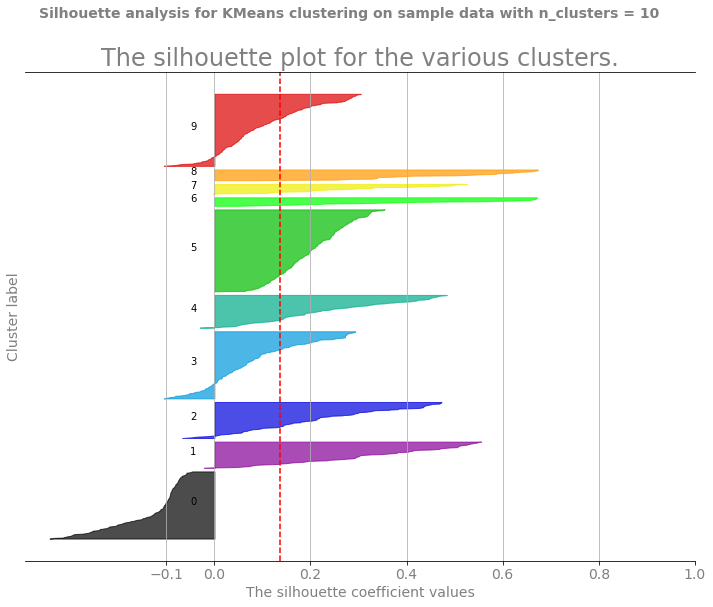

In [19]:
# Compute the SILHOUETTE score
silhouette_avg = metrics.silhouette_score(lda_csc_matrix, km.labels_)
print('Silhouette Coefficient:', silhouette_avg)


import matplotlib.cm as cm
# Compute the silhouette scores for each sample
sample_silhouette_values = metrics.silhouette_samples(lda_csc_matrix, km.labels_)

y_lower = 10
for i in range(n_clusters):
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 12
    fig_size[1] = 9
    plt.rcParams["figure.figsize"] = fig_size
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[km.labels_ == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

plt.title("The silhouette plot for the various clusters.", fontsize= 24, color='gray')
plt.xlabel("The silhouette coefficient values", color='gray', fontsize=14)
plt.ylabel("Cluster label", color='gray', fontsize=14)
## Plot Swagg ##
plt.yticks(fontsize=14, rotation=0, color='gray')
plt.xticks(fontsize=14, rotation=0, color='gray')
# plt.gca().get_legend().remove()

# Less border
plt.gca().xaxis.grid(True)
plt.gca().yaxis.grid(True)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

# The vertical line for average silhouette score of all the values
plt.axvline(x=silhouette_avg, color="red", linestyle="--")

plt.yticks([])  # Clear the yaxis labels / ticks
plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
              "with n_clusters = %d" % n_clusters),
             fontsize=14, fontweight='bold', color='gray')

plt.show()

# Labels the KMeans
Take the first 5 LDA's toplic from each cluster, then nomalize the words weight of those topics by the topic weight.  
Then take the fist 6 most relevents words in a cluster

In [20]:
class topic_label():
    def __init__(self, topic_id, value, lda_model_words):
        self.topic_id = topic_id
        self.value = value
        self.words = lda_model_words[topic_id]
    def __repr__(self):
        #return "{}".format(" ".join([word[0] for word in self.words[1]]))
        return '{}: {} {} {}'.format(self.__class__.__name__,
                                  self.topic_id,
                                  self.value,
                                  self.words
                                    )
    def __cmp__(self, other):
        if hasattr(other, 'topic'):
            return self.topic_id.__cmp__(other.topic_id)

labels = {}
lda_words = lda_model.show_topics(-1, formatted=False)
for cluster in range(n_clusters):
    values_dence = lda_csc_matrix[np.where(df['pred'] == cluster)]
    coo = values_dence.tocoo()
    
    maximize = []
    for row, col in zip(coo.row, coo.col):
        label = topic_label(col, values_dence.toarray()[row][col], lda_words)

        _filter = True

        for la in maximize:
            if la.topic_id == col and la.value <= label.value:
                _filter = True
                maximize.remove(la)
                break

            if la.topic_id == col and la.value > label.value:
                _filter = False
                
        if _filter:
            maximize.append(label)

    first5_label = (sorted(maximize, key=lambda x: x.value, reverse=True))[:5]
    
    df_label = pd.DataFrame([[label.value, label.topic_id, *[word for word in label.words[1]]] for label in first5_label])
    label_weight = df_label[0]
    label_sorted = []
    for row_index, row in df_label.iterrows():
        for col_index in range(10):
            col_index += 2
            label_sorted.append((row[col_index][0], label_weight[row_index] * row[col_index][1]))
    
    sorted_words = sorted(label_sorted, key=lambda x: x[1], reverse=True)[:6]
    labels[cluster] = [w for (w, weight) in sorted_words]

## Distribution of idea over the years

In [21]:
# Year sampling, (-> ['2004 to 2006', '2007 to 2009', .. ])
NUM_OF_SEP = 5 # number of partition

In [22]:
# Group the year, while keeping the prediction dissimilarity AND count the number of article for onw prediction
A = df.groupby(['year', 'pred']).agg({'pred': ['count']})

# Result is MultiIndex dataframe
display(A.query('year <= 2006').T)

df_label_count_sampled_year = pd.DataFrame(index=[x for x in range(n_clusters)])

start = pd.Timestamp('2004')
end = pd.Timestamp('2018')
ye_sampling = np.linspace(start.value, end.value, NUM_OF_SEP)
ye_sampling = pd.to_datetime(ye_sampling).year
display(ye_sampling)

# For each year's partitions
for start, end in zip(ye_sampling[:-1], ye_sampling[1:]):
    
    # query the current partition into the df
    _splited_df = A.query('year >= '+ str(start) + ' & year < ' + str(end+1)) 

    # label conter for each year of the partition
    from collections import defaultdict
    class_count = {}
    class_count = defaultdict(lambda:0, class_count)

    for ((year, label_id, a), count_obj) in _splited_df.stack().iterrows():
        class_count[label_id] += count_obj[0]
        # VERBOSE
        # print("Year {} has a label {:3} documents related to the label id: {:3}".format(year, count_obj[0], label_id ))

    # total of document for each label of the current partition
    class_count = dict(class_count)
    # VERBOSE
    # display(class_count)

    df_label_count_sampled_year["{} - {}".format(start, end)] = pd.Series(class_count)

# To percent
df_label_count_sampled_year = df_label_count_sampled_year.apply(lambda x: x / x.sum(), axis=1)

display(df_label_count_sampled_year)

year       2004                            2005 ... 2006                               
pred          0  1   2   3  4   5  6  8  9    0 ...    0  1   2   3  4   5  6  7  8   9
pred count   18  2  13  15  8  15  2  1  8   17 ...   23  5  11  18  6  14  4  3  2  17

[1 rows x 28 columns]

Int64Index([2004, 2007, 2011, 2014, 2018], dtype='int64')

,2004 - 2007,2007 - 2011,2011 - 2014,2014 - 2018
0,0.264228,0.382114,0.191057,0.162602
1,0.183486,0.339450,0.275229,0.201835
2,0.340741,0.296296,0.140741,0.222222
3,0.242678,0.313808,0.171548,0.271967
4,0.280992,0.371901,0.140496,0.206612
5,0.245955,0.320388,0.197411,0.236246
6,0.433333,0.300000,0.066667,0.200000
7,0.219512,0.292683,0.195122,0.292683
8,0.075000,0.250000,0.275000,0.400000
9,0.154676,0.255396,0.258993,0.330935


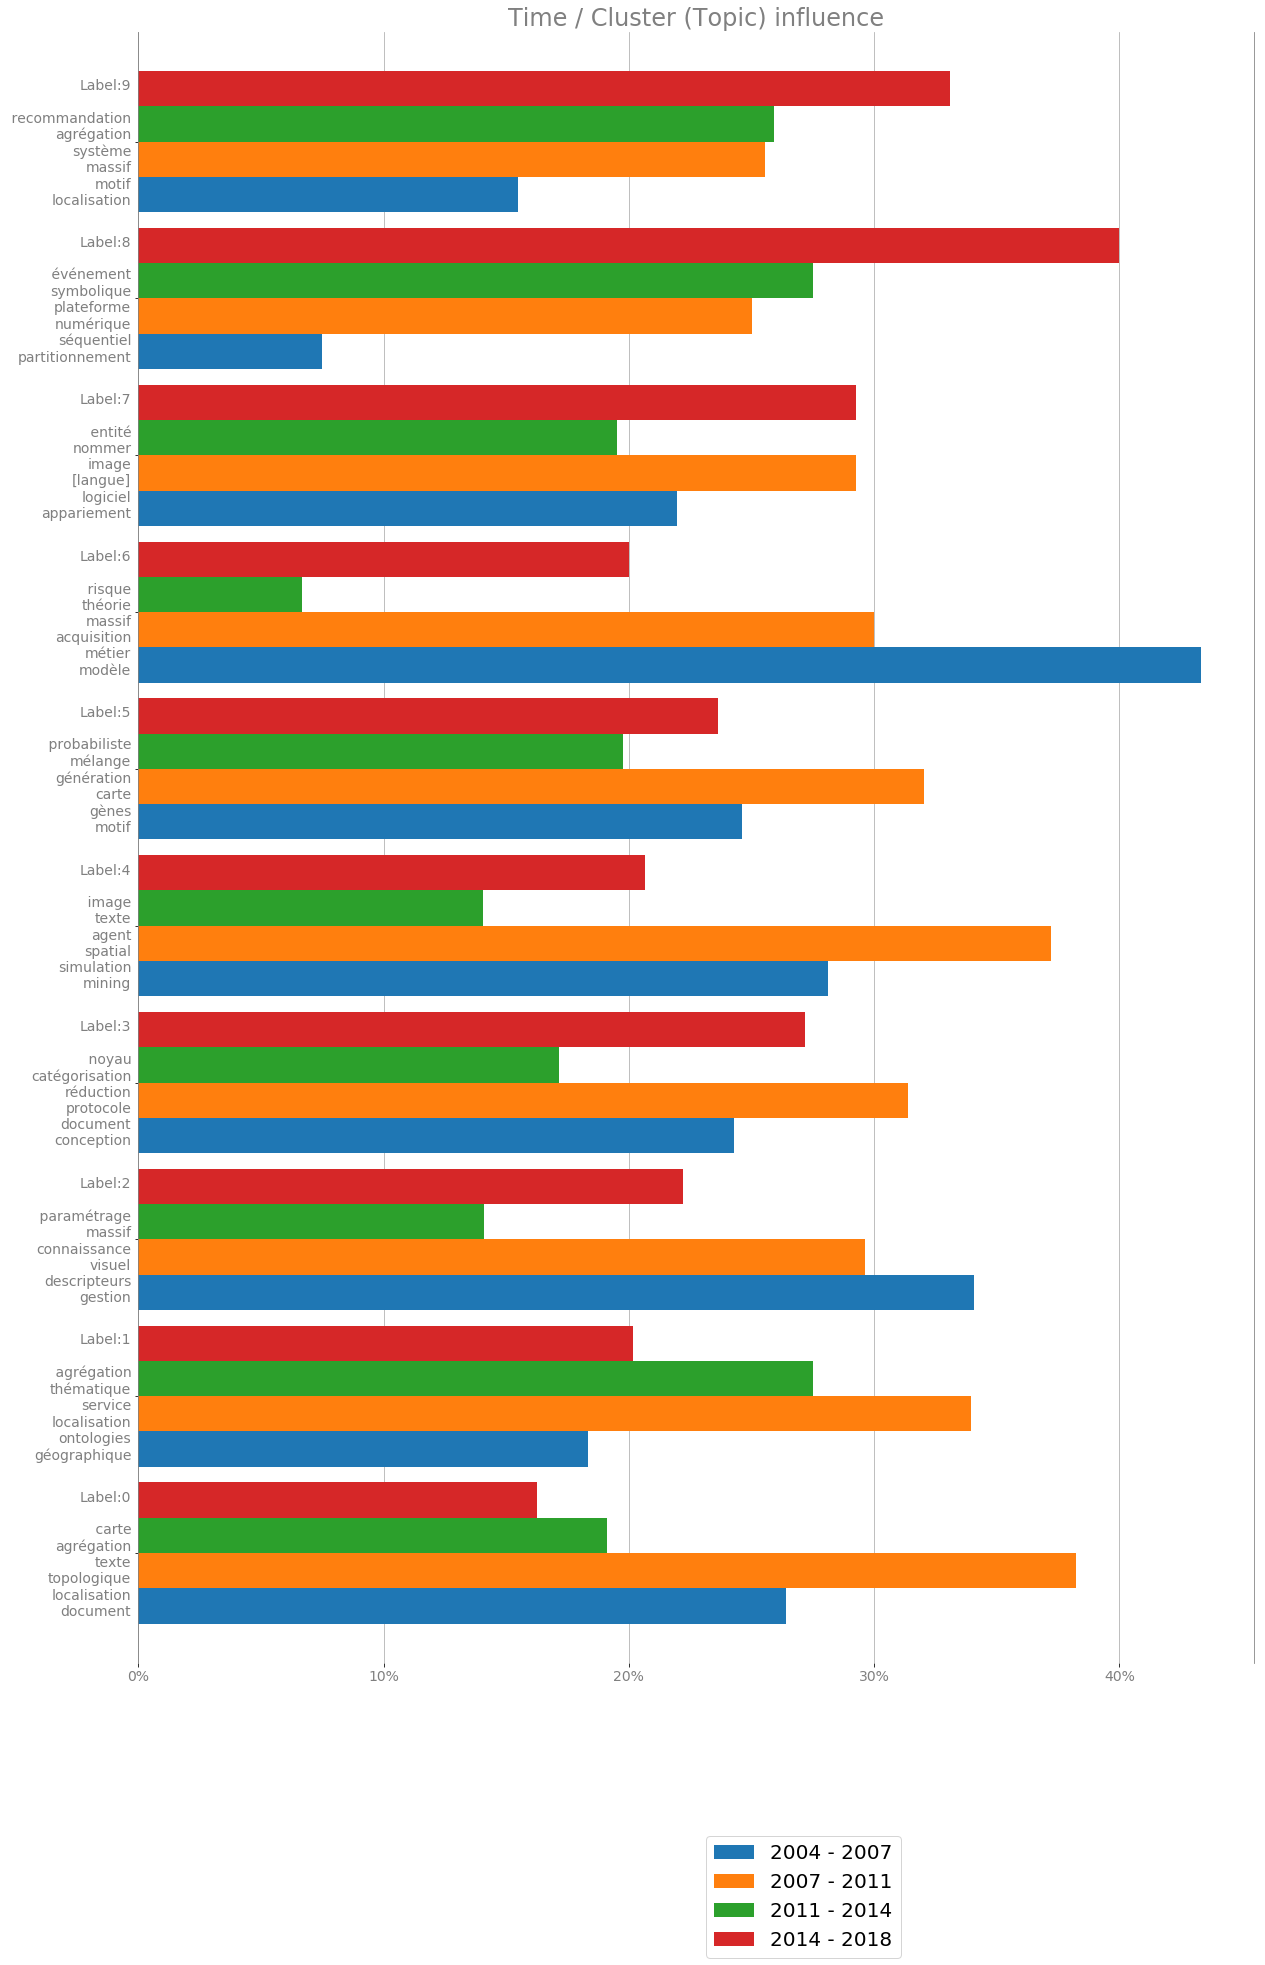

In [23]:
from matplotlib.ticker import FuncFormatter

# Plot
df_label_count_sampled_year.plot.barh(figsize=(20, 30), width=0.9)
plt.title('Time / Cluster (Topic) influence', fontsize= 24, color='gray')

## PlotSwagg ##
plt.yticks(fontsize=14, rotation=0, color='gray')
plt.xticks(fontsize=14, rotation=0, color='gray')

# Cleanest Percent
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x))) 
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: 'Label:{}\n\n {}'.format(str(y), "\n".join(labels[y]))))

# Less border
plt.gca().xaxis.grid(True)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_edgecolor('gray')
plt.gca().spines['right'].set_edgecolor('gray')
plt.legend(loc=2, prop={'size': 20}, bbox_to_anchor=(0.5, -0.1))

# Percent line under the barH
plt.gca().set_axisbelow(True)

plt.show()

In [24]:
# Dump 
if False:
    lda_model.save('LDA_model.gensim')
    id2word.save('dictionary.gensim')
    pickle.dump(bow_corpus, open('corpus.pkl', 'wb'))